## For the anchors to work (links in q&a and index), please use a notebook viewer:

https://nbviewer.jupyter.org/github/justinmlam/yelp_in_vancouver/blob/master/yelp_project.ipynb

# Questions and their answers (click to redirect to answer)

"How much is quality of food weighed against other factors of the experience? (ambiance, service etc)"

"What is the most highly rated category of restaurant?"

"What restaurant categories don't exist in Vancouver?"

[Summary Statistics](#summary-statistics)




# Index (click to redirect to section)

## [Data pre-processing](#data-preprocessing)
- [Clean the data](#clean-the-data)

## [Summary Statistics](#summary-statistics)
- Overall assessment of review_count, rating, price
- Categorical assessment of review_count, rating, price, total number
- Geographic Data





# Notes:
a quick google search says there are >5000 restaurants in vancouver.

using the yelp api, 3800 restaurants were able to be extracted, so about 75% of restaurants were found. API does not return businesses without any reviews, so that may be the cause for the missing data.

<a id="data-preprocessing"></a>

# Data Pre-processing
Read in the data and convert it to dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from yelphelpers import *

with open('data/vancouver_restaurants.json') as f:
    data = json.load(f)
    
with open('data/categories.json') as f:
    cats = json.load(f)

In [2]:
df = pd.DataFrame.from_dict(data, orient='columns')

<a id="clean-the-data"></a>

### Clean the data

Remove unnecessary data

One-hot encode categories list

Convert string data into numberic data (rating, price)

Add neighbourhood name based on zip code

In [3]:
# categories of restaurants in a list
restaurant_cats = [place['title'] for place in cats if 'restaurants' in place['parents']]

In [4]:
#  Remove unnecessary data
df = df.drop(columns=['image_url','is_closed','transactions','phone','display_phone'])
# replace number signs ($) with decimals
df.replace(['$','$$','$$$','$$$$'],[1.0,2.0,3.0,4.0], inplace=True)

# TODO::: Expand the list, "categories" into separate columns


df_categories = df[['id', 'categories']]
df.drop(columns=['categories'],inplace=True)
df.rename(columns={'alias':'r_alias'},inplace=True)

df_expanded = df.copy().merge(expand_list(df_categories.copy(), 'categories'))
df_categories = expand_list(df_categories,'categories')
df_categories = pd.concat([df_categories.drop(['categories'], axis=1), df_categories['categories'].apply(pd.Series)], axis=1)
df_categories = df_categories.groupby(['id']).agg(lambda x: tuple(x)).applymap(list).reset_index()

df = df.merge(df_categories, on='id')
df = df.drop('alias', 1).join(df.alias.str.join('|').str.get_dummies())


# df_expanded: each restaurant has more than 1 category. df_expanded separates them into different entries.
#     meaning, df_expanded has duplicated
# df: does not have duplicates.
df_expanded = pd.concat([df_expanded.drop(['categories'], axis=1), df_expanded['categories'].apply(pd.Series)], axis=1)

#____________________________________________________________________________
# df_alias_title = df[['id','alias','title']]
# df = expand_list(df,'categories')
# df.rename(columns={'alias':'r_alias'},inplace=True)
# df = pd.concat([df.drop(['categories'], axis=1), df['categories'].apply(pd.Series)], axis=1)
# df_alias_title = df[['id','alias','title']]
# df_alias_title = df_alias_title.groupby(['id']).agg(lambda x: tuple(x)).applymap(list).reset_index()
# df.drop(columns=['alias','title'],inplace=True)
# df = df.merge(df_alias_title, on='id')
# # One-hot encode categories to be able to be used
# df = df.drop('title', 1).join(df.title.str.join('|').str.get_dummies())
#____________________________________________________________________________



# clean up some variables to leave more space
# df_categories = None

### This is the markdown cell for anchor (double click me)
<a id="summary-statistics"></a>

### Summary Statistics

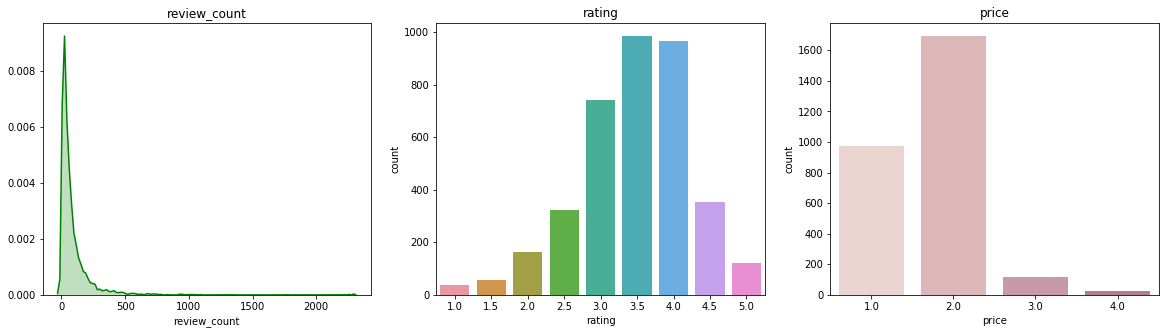

In [5]:
# review_count, rating, price

# review_count - line graph
# rating - histogram
# price - histogram

fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.set_palette(sns.cubehelix_palette(8))
sns.distplot(df['review_count'], hist=False, color="g", ax=axes[0], kde_kws={"shade": True}).set_title('review_count')
sns.countplot(df['rating'],ax=axes[1]).set_title('rating')
sns.countplot(df['price'],ax=axes[2]).set_title('price')
plt.show()

In [6]:
# df_categories.head()
# We will be looking at category vs review_count, rating, coordinates, price, total  number
# because there are different number for each, we will be getting their average

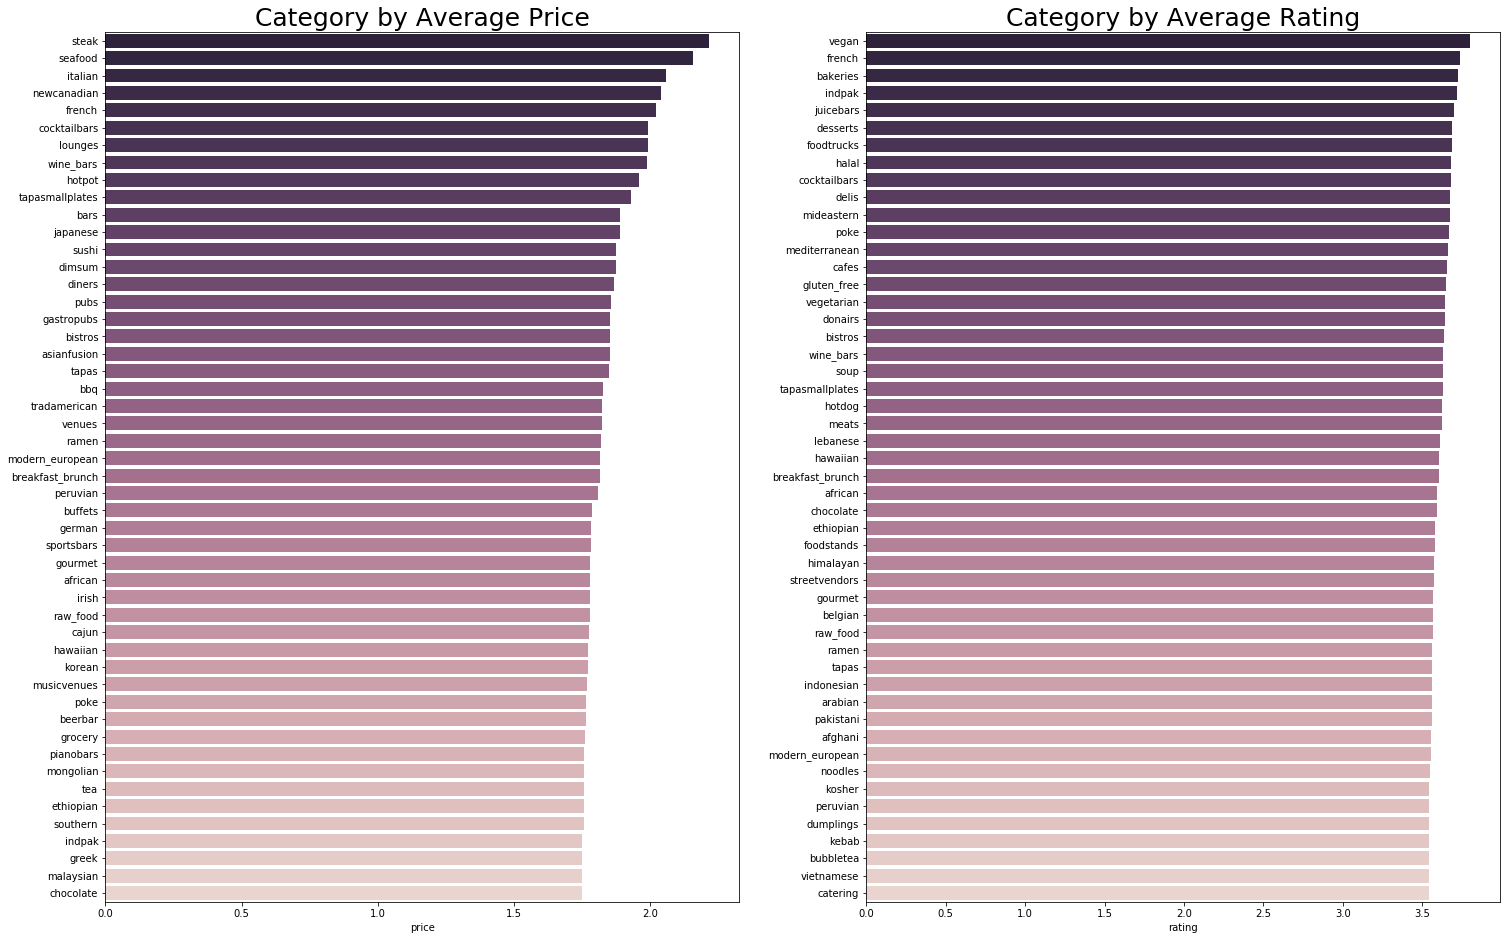

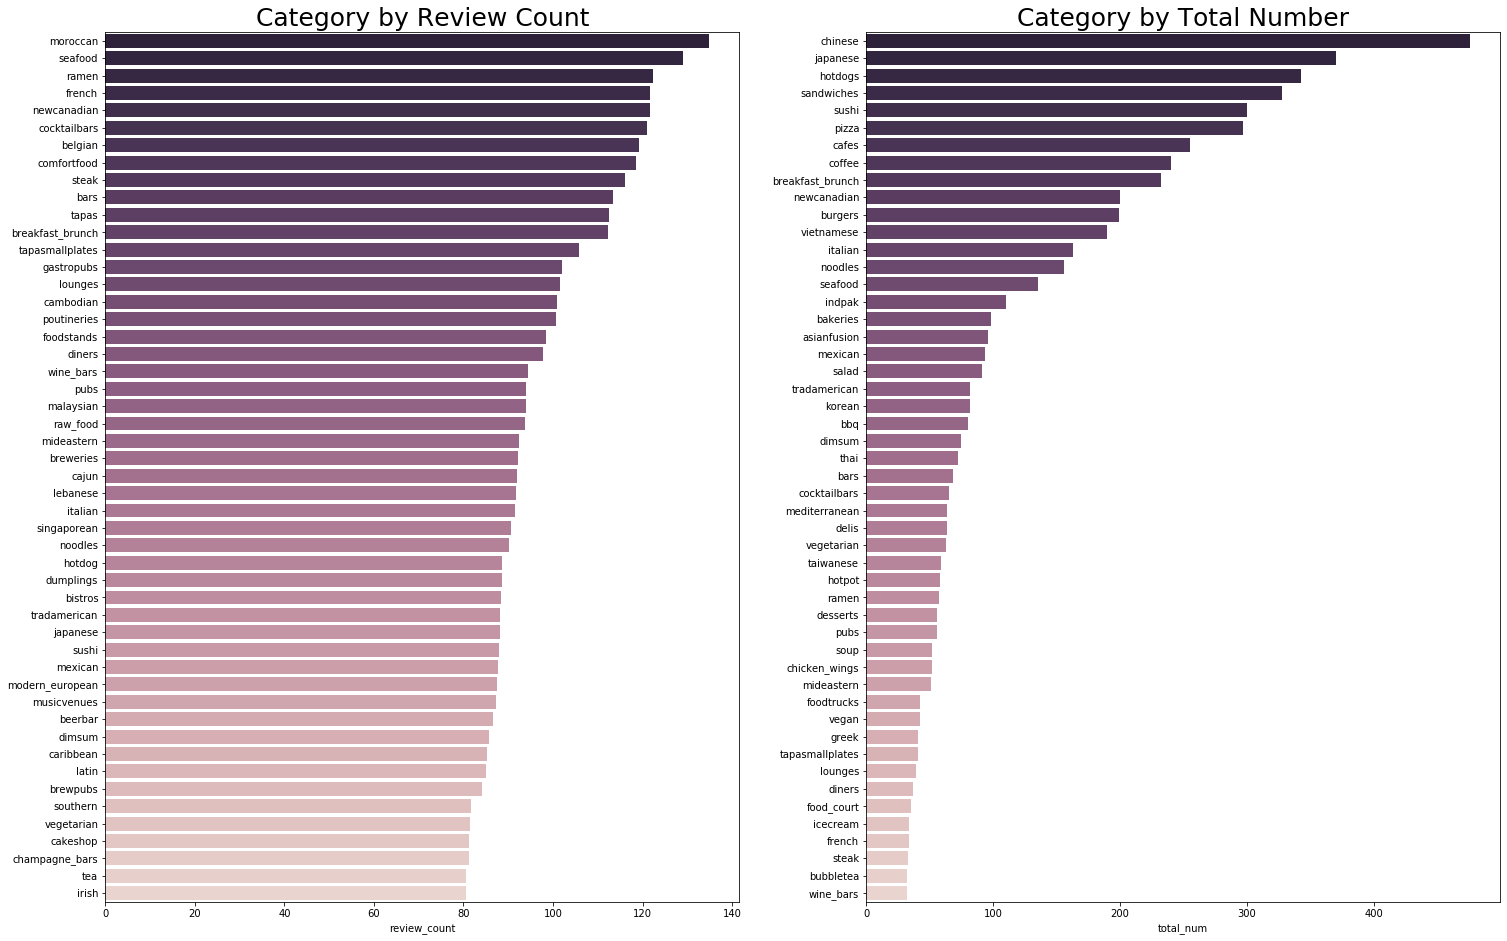

In [7]:
n = 50

### PRICE ###
pr = (bayes_avg(df_expanded.dropna(how='any'), 'alias', 'price').sort_values(ascending=False)
     .reset_index().sort_values('price', ascending=False))
pr = pr.iloc[:n]


### RATING
ra = (bayes_avg(df_expanded, 'alias', 'rating').sort_values(ascending=False)
     .reset_index().sort_values('rating', ascending=False))
ra = ra.iloc[:n]

### REVIEW_COUNT
re = (bayes_avg(df_expanded, 'alias', 'review_count').sort_values(ascending=False)
     .reset_index().sort_values('review_count', ascending=False))
re = re.iloc[:n]

### NUMBER OF RESTAURANTS
nu = (df.drop(['id', 'r_alias', 'name','url','review_count','rating','coordinates','price','location', \
         'distance', 'title'], axis=1).sum().sort_values(ascending=False))
nu = nu.reset_index().iloc[:n]
nu.rename(columns={'index': 'alias', 0:'total_num'}, inplace=True)




# first fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette(sns.cubehelix_palette(8))
sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

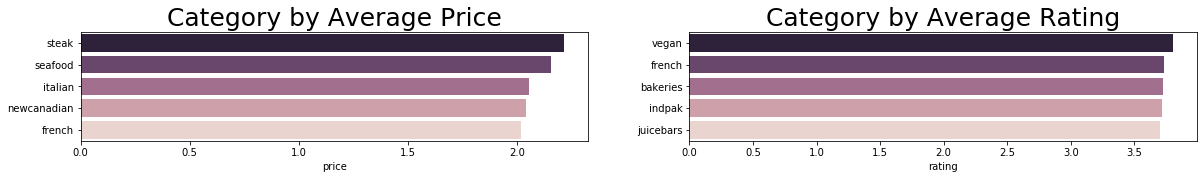

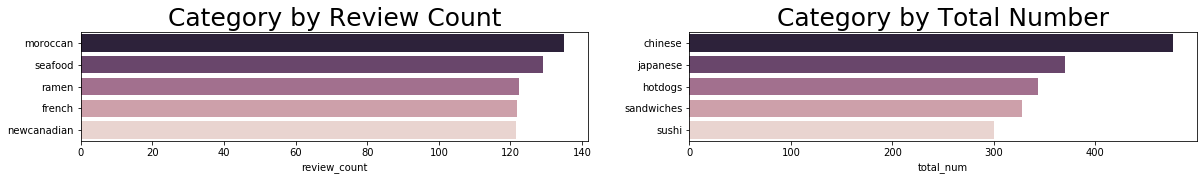

In [8]:
# let's map the top 5 of each category
m = 5

pr = pr.iloc[:m]
ra = ra.iloc[:m]
re = re.iloc[:m]
nu = nu.iloc[:m]

fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette(sns.cubehelix_palette(8))
sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

# Geographic Data

I was able to find a geoJSON file that has Vancouver zip code boundary coordinates.

Thank you to codeforamerica on github for this file.

https://github.com/codeforamerica/click_that_hood/blob/master/public/data/vancouver.geojson

This task was not easy.

The Vancouver geojson file did not include an easily usable "key" for my data to attach to, such as a zip code, so I had to solve the problem of working with the key "name": which is the name of the region.

Using this site: https://www.geonames.org/postal-codes/CA/BC/british-columbia.html, I was able to find the zip code respective to the areas that I wanted to use.

With that, came the work of trying to create a new column that corresponded to the "key" in the geojson file. I mapped the zip code to the exact name of the area in question.


Unfortunately, this geojsn file only includes Vancouver. This means that the restaurants in North Vancouver, West Vancouver, Burnaby, and Richmond are not included in the maps.



Currently, this is not done. 

TODO:
Map in your DF, a new column that corresponds to the key, "name", in the geojson file.

In [9]:
import folium

with open('data/vancouver.geojson','r') as f:
    geojson = json.load(f)

# edit current dataframe to be readable by folium
df['zip_code'] = pd.concat([df.drop(['location'], axis=1), df['location'].apply(pd.Series)], axis=1)['zip_code']

Applying zip code to location:

In [10]:
df['length'] = df['zip_code'].apply(lambda x: len(x))
df['length'].value_counts()

7    3594
3     131
0      25
5       2
Name: length, dtype: int64

Looks like the zip data comes in different lengths.

Exploring the data, zip codes that have a length of 3 and 7 are in postal code format. Zip codes with length 5 are in the form of American zip codes. Because there are only 27 missing zip codes, we will ignore those.

In [12]:
def zip_to_location(zip_code):
    zip_to_loc_dict = {"V6N": "Dunbar Southlands",
                       "V5K": "Hastings-Sunrise",
                       "V5T": "Mount Pleasant",
                       "V6Z": "Downtown",
                       "V6B": "Downtown",
                       "V7X": "Downtown",
                       "V7Y": "Downtown",
                       "V6E": "West End",
                       "V6G": "West End",
                       "V7T": "West End",
                       "V5S": "Killarney",
                       "V6M": "Kerrisdale",
                       "V5X": "Sunset",
                       "V6P": "Marpole",
                       "V6K": "Kitsilano",
                       "V6R": "Kitsilano",
                       "V6J": "Fairview",
                       "V5P": "Victoria-Fraserview",
                       "V6S": "West Point Grey",
                       "V5W": "Oakridge",
                       "V5R": "Renfrew-Collingwood",
                       "V5M": "Renfrew-Collingwood",
                       "V5V": "Riley Park",
                       "V5Y": "Riley Park",
                       "V6H": "Shaughnessy",
                       "V5L": "Grandview-Woodland",
                       "V5N": "Kensington-Cedar Cottage",
                       "V6L": "Arbutus Ridge",
                       "V5Z": "South Cambie",
                       "V6A": "Downtown Eastside"}
    
    if len(zip_code) == 5 or len(zip_code) == 0:
        return ''
    else:
        return zip_to_loc_dict.get(zip_code[:3], zip_code[:3])

    return "None" 

df['area'] = df['zip_code'].apply(zip_to_location)

In [13]:
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=12
)


vancouver_map.choropleth(geo_data=geojson,
                         data=df,
                         columns=['area', 'rating'],
                         key_on='feature.properties.name',
                         fill_color='YlGn',
                         fill_opacity=0.7,
                         line_opacity=0.2,
                         nan_fill_color='black',
                         nan_fill_opacity=0.2)

vancouver_map


### In this map: missing data is in grey.
### Reasoning for this: Zip code "V6A" is both Strathcona and Downtown Eastside, so they can't be placed into both.

C:\Users\justi\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
